# Cost Analysis on AWS Managed NAT Gateway

## Intro



## Assumptions

* Pricing based on ap-northeast-1
* EC2-based solutions and Managed NAT Gateway can only support half bandwidth from interface

In [1]:
K = 1024
MB = 1024 * K
GB = 1024 * MB
TB = 1024 * GB
PB = 1024 * TB
BITS_PER_BYTE = 8
HOURS_PER_MONTH = 30 * 24
SECONDS_PER_MONTH = HOURS_PER_MONTH * 60 * 60
GBPS_TO_BYTES_PER_MONTH = GB * SECONDS_PER_MONTH / BITS_PER_BYTE

### Config

In [2]:
# #deployments required, 2 NATGW as that resides in an AZ
HA_MULTIPLIER = 2

# Bandwidth * Efficiency = Data transfer rate out
NIC_EFFICIENCY_SH = 0.5
NIC_EFFICIENCY_NAT = 0.5

In [3]:
COST_DATA = [ # Cost on data transfer, per month
    {
        "cap": 1 * GB,
        "per_gb": 0.0,
    },
    {
        "cap": 10 * TB,
        "per_gb": 0.14
    },
    {
        "cap": 40 * TB,
        "per_gb": 0.135,
    },
    {
        "cap": 100 * TB,
        "per_gb": 0.130,
    },
    {
        "cap": 350 * TB,
        "per_gb": 0.120,
    },
    {
        "cap": float("inf"),
        "per_gb": 0.120, # It says `contact us`
    }
]
    

COST_GW = {
    "hourly": 0.062,
    "per_gb": 0.062,
    "capability_gbps": 10,
}

COST_SH = [
    {
        "name": "t2.small",
        "hourly": 0.0304,
        "capability_gbps": 0.2,
    },
    {
        "name": "m3.medium",
        "hourly": 0.096,
        "capability_gbps": 0.5,
    },
    {
        "name": "m4.xlarge",
        "hourly": 0.258,
        "capability_gbps": 1,
    },
    {
        "name": "c4.4xlarge",
        "hourly": 1.008,
        "capability_gbps": 2,
    },
    {
        "name": "c4.8xlarge",
        "hourly": 2.016,
        "capability_gbps": 10,
    },
    {
        "name": "m4.16xlarge",
        "hourly": 4.128,
        "capability_gbps": 25,
    },
    
]

## Code

In [4]:
%matplotlib inline

In [5]:
def plot_table(array, column_color, row_color, zebra_color):
    return None
    from ipy_table import make_table, set_column_style, set_row_style
    from IPython.display import display_html
    
    table = make_table(array)
    
    for c in range(2, len(array), 2):
        set_row_style(c, color=zebra_color)

    set_column_style(0, color=column_color)
    set_row_style(0, color=row_color)

    display_html(table)

In [6]:
def cf(f):
    """
    Column title filter, adds comma (',') as thousand separators
    """
    import locale
    locale.setlocale(locale.LC_ALL, 'en_US')
    return locale.format("%.1f" if type(f) is float else "%d", f, grouping=True)

def nf(f, digits=2):
    """
    Number (float) filter
    """
    tpl = ".%df" % digits
    return ("%" + tpl) % f

In [7]:
def _cost_on_transfer(data_bytes):
    costs = 0.0
    for tier in COST_DATA:
        amt_this_tier = min(tier['cap'], data_bytes)
        costs += amt_this_tier * tier['per_gb'] / GB
        data_bytes -= amt_this_tier
        
        if data_bytes <= 0:
            break
    return float(costs)

def _net_capability_bytes(capability_gbps, nic_efficiency):
    return capability_gbps * GBPS_TO_BYTES_PER_MONTH * HA_MULTIPLIER * nic_efficiency

In [8]:
def cost_managed_nat_with_transfer(data_bytes):
    max_possible_bytes = _net_capability_bytes(
        COST_GW['capability_gbps'], 
        NIC_EFFICIENCY_NAT)
    
    return float("nan") if data_bytes > max_possible_bytes else \
        HA_MULTIPLIER * (COST_GW['hourly'] * HOURS_PER_MONTH) + \
        data_bytes * COST_GW['per_gb'] / GB + \
        _cost_on_transfer(data_bytes)

def cost_self_hosted_nat_with_transfer(data_bytes, tier):
    max_possible_bytes = _net_capability_bytes(
        tier['capability_gbps'], 
        NIC_EFFICIENCY_SH)
    
    return float("nan") if data_bytes > max_possible_bytes else \
        tier['hourly'] * HOURS_PER_MONTH * HA_MULTIPLIER + \
        _cost_on_transfer(data_bytes)

In [9]:
def amortized_managed_nat_cost_per_gb(data_bytes):
    total_cost = cost_managed_nat_with_transfer(data_bytes)
    total_gb = data_bytes / GB
    return total_cost / total_gb
    
def amortized_self_hosted_cost_per_gb(data_bytes, tier):
    total_cost = cost_self_hosted_nat_with_transfer(data_bytes, tier)
    total_gb = data_bytes / GB
    return total_cost / total_gb

In [10]:
def plot_range(bytes_lbound, bytes_ubound, points=100, title=""):
    import numpy as np
    import matplotlib.pyplot as plt

    bytes_transferred = np.linspace(bytes_lbound, bytes_ubound, points)
    bytes_transferred_in_gb = bytes_transferred / GB
    
    plt.figure(figsize=(12,8), )
    plt.plot(
        bytes_transferred_in_gb, 
        [cost_managed_nat_with_transfer(bt) for bt in bytes_transferred], 
        label="natgw"
    )
    
    for tier in COST_SH:
        plt.plot(
            bytes_transferred_in_gb,
            [
                cost_self_hosted_nat_with_transfer(bt, tier) 
                for bt in bytes_transferred
            ],
            label=tier['name'])
    
    plt.legend(loc=0)
    plt.xlabel("Data Transferred (GB) in a Month")
    plt.ylabel("Total Cost (USD)")
    plt.axis('tight')
    
    plt.title(title)

## Results

### Prorated Rates (USD / GB Out)

In [11]:
monthly_outbound_tb = [0.001, 0.5, 1, 2, 4, 8, 16, 32, 64, 256, 1024, 4096]

plot_table([
    ["Monthly Data Out (TB)"] + 
    [cf(vol) for vol in monthly_outbound_tb],
    ["NAT GW"] + 
    [nf(amortized_managed_nat_cost_per_gb(amt * TB), 3) for amt in monthly_outbound_tb]
] + [
    [tier['name']] + 
    [nf(amortized_self_hosted_cost_per_gb(amt * TB, tier), 3) for amt in monthly_outbound_tb]
    for tier in COST_SH
], 'lightpink', 'lightblue', '#EEE')

/Users/clifflu/.virtualenvs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  import sys


### Total Cost Projection

In [12]:
plot_table([
    ["Monthly Data Out (TB)"] + 
    [cf(vol) for vol in monthly_outbound_tb],
    ["NAT GW"] + 
    [nf(cost_managed_nat_with_transfer(amt * TB)) for amt in monthly_outbound_tb],
] + [
    [t['name']] + 
    [nf(cost_self_hosted_nat_with_transfer(amt * TB, t)) for amt in monthly_outbound_tb] 
    for t in COST_SH
], "lightpink", "lightcyan", "#EEE")


/Users/clifflu/.virtualenvs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  import sys


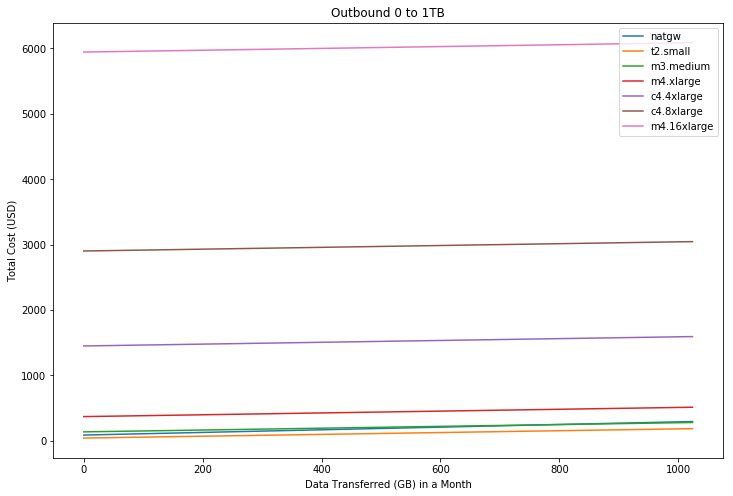

In [13]:
plot_range(0, 1 * TB, title="Outbound 0 to 1TB")

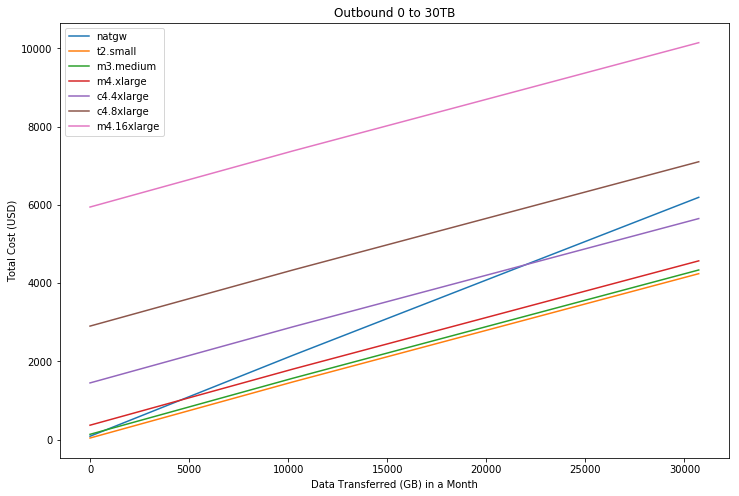

In [14]:
plot_range(0, 30 * TB, title="Outbound 0 to 30TB")


Managed NAT Gateway is competitive with monthly outbound belwo 30TB.

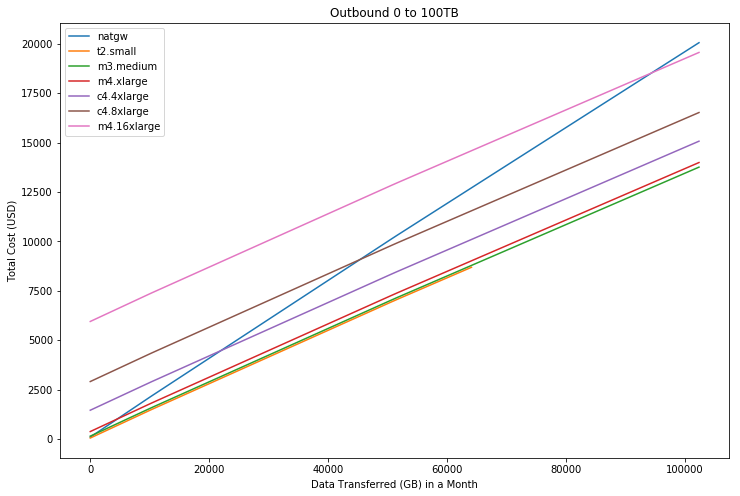

In [15]:
plot_range(0, 100 * TB, title="Outbound 0 to 100TB")


It becomes less efficient compared to EC2-based solutions with 60+ TB oubound per month.

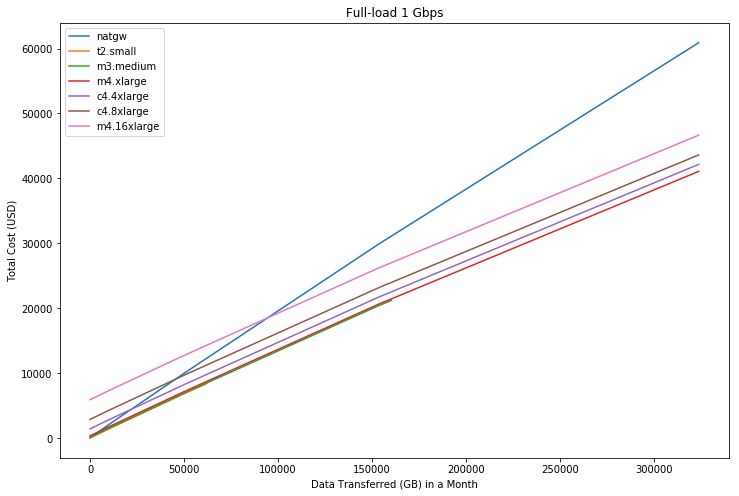

In [16]:
plot_range(0, 1 * GBPS_TO_BYTES_PER_MONTH, title="Full-load 1 Gbps")


A pair of t2.small instances would fail at ~0.4 Gbps.

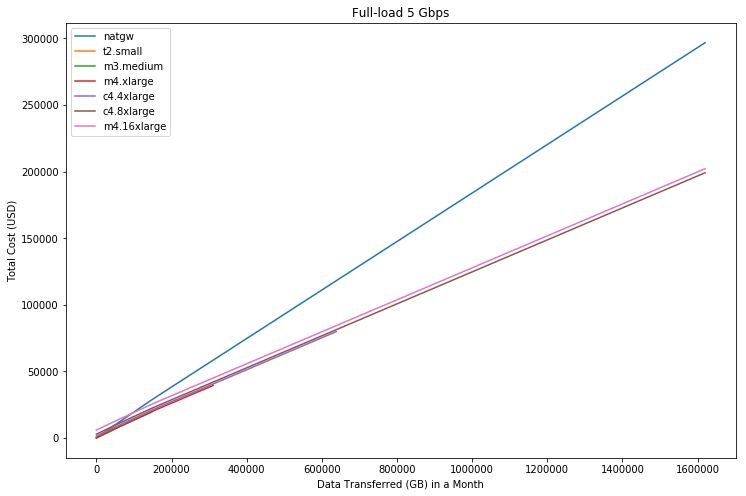

In [17]:
plot_range(0, 5 * GBPS_TO_BYTES_PER_MONTH, title="Full-load 5 Gbps")


## Conclusion

* AWS Managed NAT Gateway is the perferred solution with monthly outbound traffic below 5TB. It's feasible up to 20TB/month, at similar rate from c4.4xlarge.
* Hourly rate $0.062 ($46/mo) isn't high, don't hesitate on having one in every AZ used.
* Additional 50% data transfer rate makes it less favorable beyond 50TB/month
* Auto-scaled proxy cluster can offload traffic at 10% instead of 50% extra (w/o caching)
* If your stack reads alot (from internet), go public.
